# Interpretability of Random Forest classifier using SHAP values: How to understand better your customers?

<a id='table'></a>
## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#dw">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#prep">Preparing Dataset to the Model</a></li>
<li><a href="#rfc">Random Forest Classifier</a></li>
<li><a href="#shap">SHAP Values</a></li>
<li><a href="#summary">Summary</a></li>
<li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this notebook I used Random Forest classifier and SHAP values to get a better understanding of the customers. Also, I was curious about what can be done in the next campaign to increase CVR (Conversion Rate). After conducting EDA, I got the following business questions:
1. What kind of characteristics have people who placed a deposit?
2. What kind of characteristics have people who did NOT place a deposit?
3. Based on the available data, what can be done next time to increase CVR?

### Data

I used the following [dataset](https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset/data) with results of Portugal bank marketing campaigns. Conducted campaigns were based mostly on direct phone calls, offering bank client to place a term deposit. If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'.

**Input variables**

**Bank client data:**

* 1 - age (numeric)

* 2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

* 3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

* 4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

* 5 - default: has credit in default? (categorical: "no","yes","unknown")

* 6 - housing: has housing loan? (categorical: "no","yes","unknown")

* 7 - loan: has personal loan? (categorical: "no","yes","unknown")
related with the last contact of the current campaign:

* 8 - contact: contact communication type (categorical: "cellular","telephone")

* 9 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

* 10 - dayofweek: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**Other attributes:**

* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

* 14 - previous: number of contacts performed before this campaign and for this client (numeric)

* 15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

social and economic context attributes

* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)

* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

* 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

* 21 - y - has the client subscribed a term deposit? (binary: "yes","no")

**Missing Attribute Values**: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

### Motivation

I was curious to apply SHAP values to interpret a classification model obtained by training Random Forest. Also, this notebook is a part of [Data Scientist Nanodegree Program](https://www.udacity.com/course/data-scientist-nanodegree--nd025) provided by [Udacity](https://www.udacity.com).

<a id='dw'></a>
## Data Wrangling

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# df.info()

In [6]:
# Looking for NULL values in the dataset
df.isnull().sum().sum()

0

In [7]:
# Looking for duplicates in the dataset
sum(df.duplicated())

12

In [8]:
# Let's have a look on the duplicated values
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


Some values in the columns have duplicated values. However, there is no duplicated rows in the dataset.

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

Let us explore the dataset and put at least three questions related to business.

In [9]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


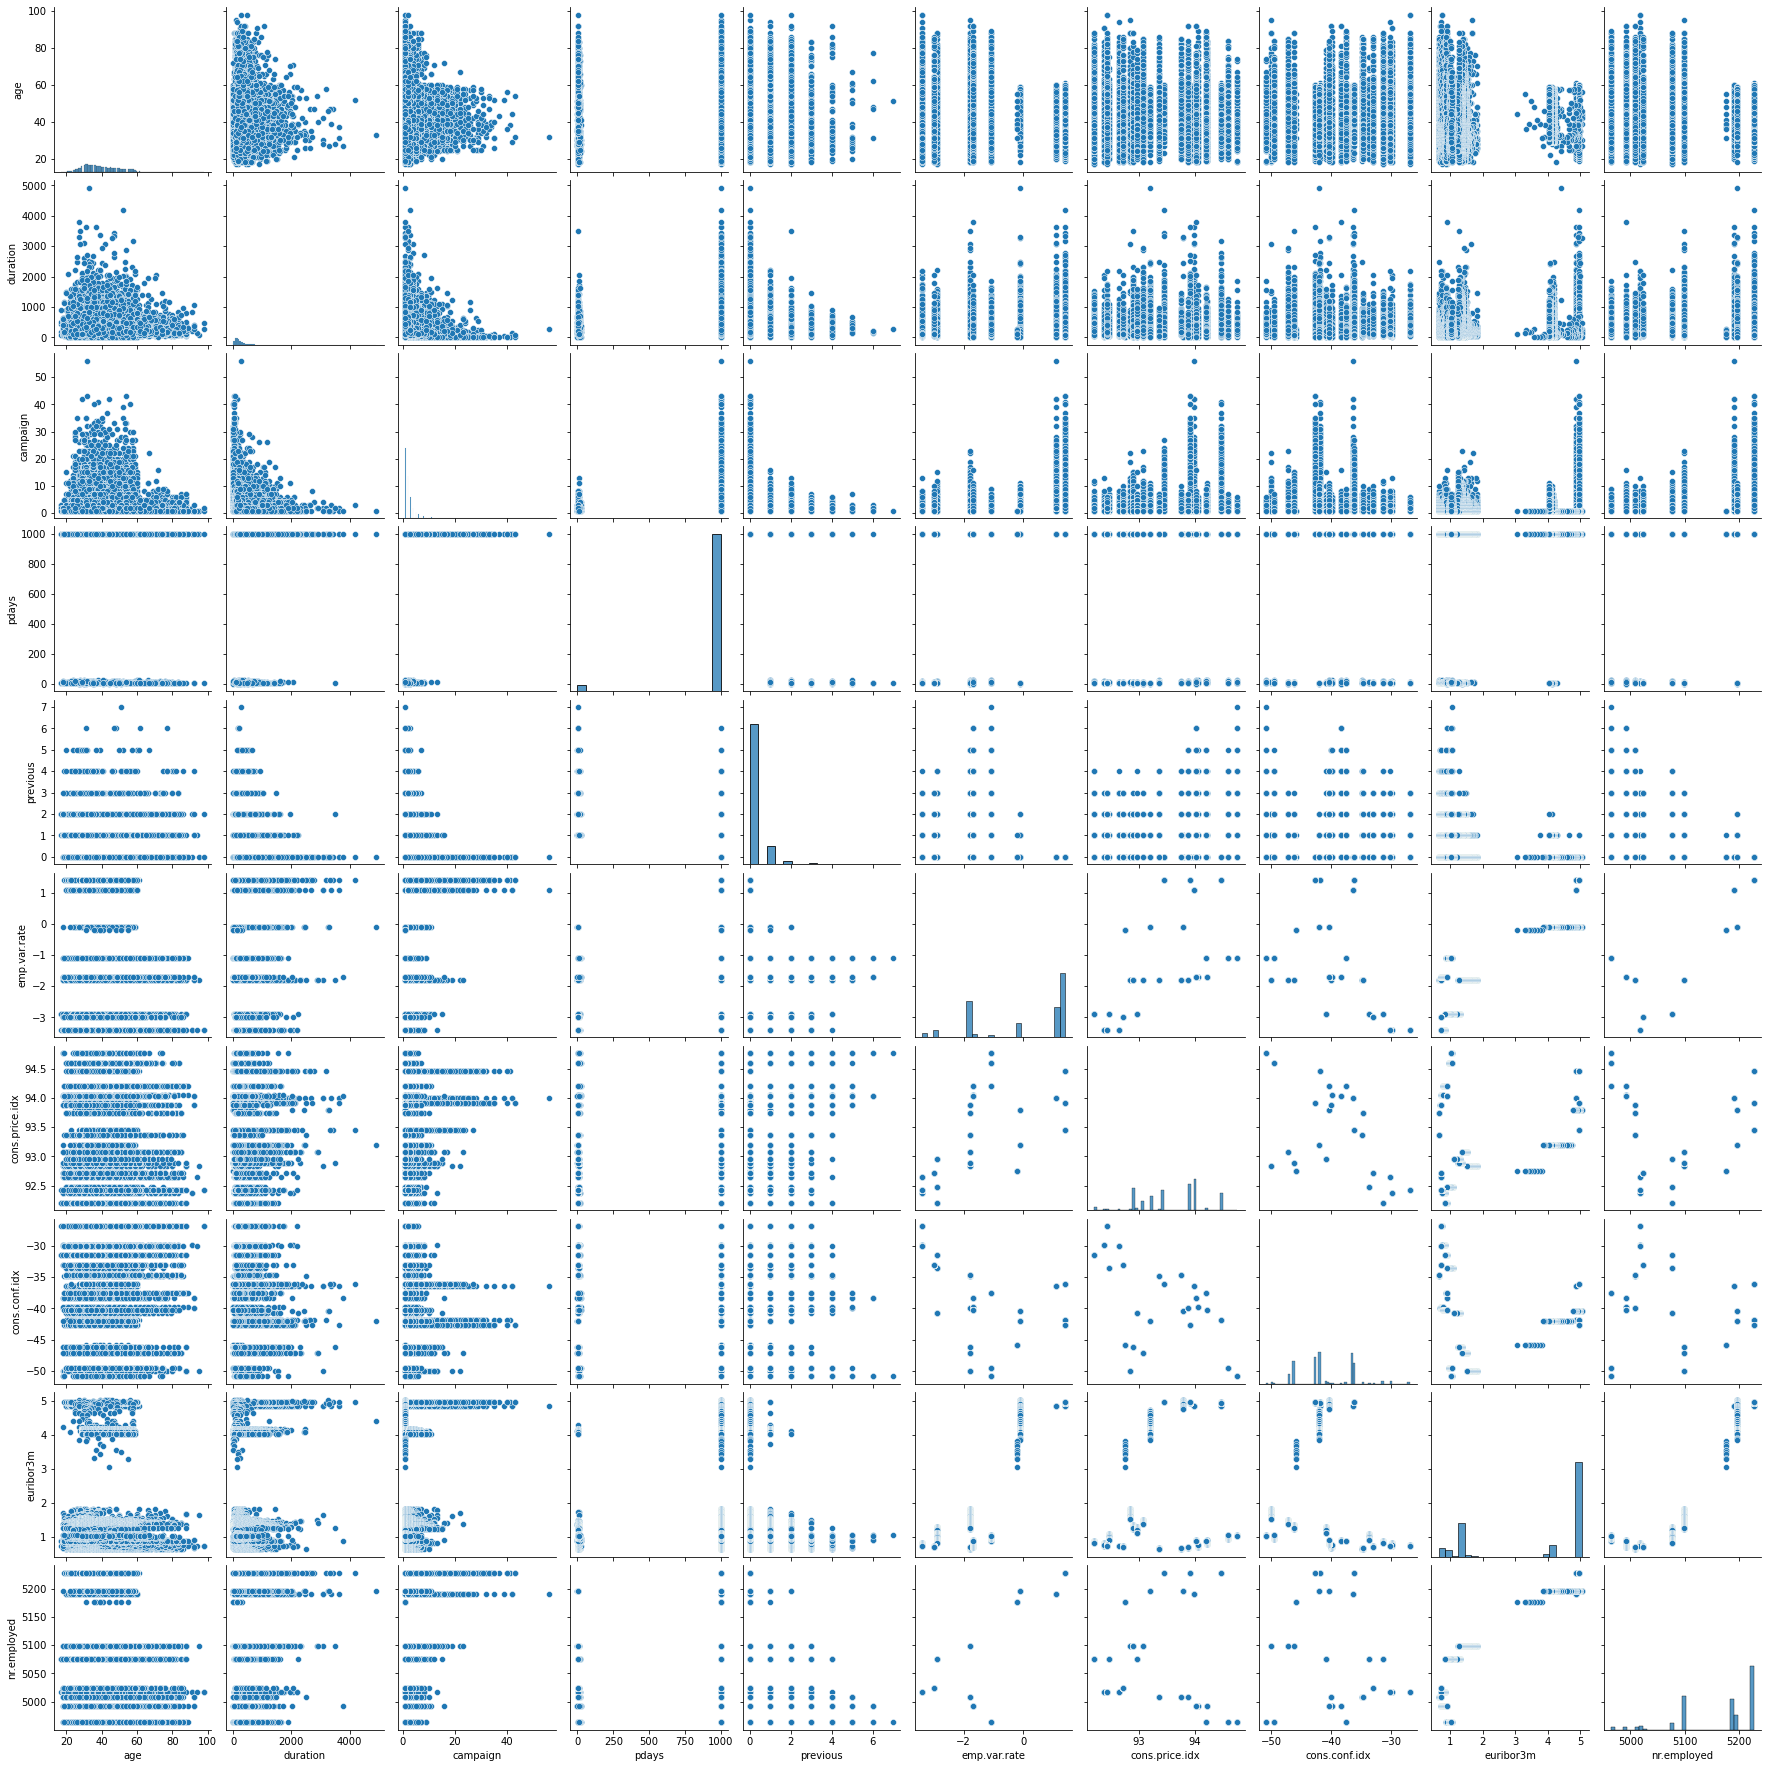

In [10]:
# Let's have a look on a pairplot to check whether we have any anomalies and/or any structural issues 
sns.pairplot(df);

I could not find any suspicious data in the attributes. Also, I do not know how some attributes such as 'euribor3m', 'nr.employed', 'emp.var.rate', 'cons.conf.idx' were obtained.

In [11]:
# Let's have a look on data correlation matrix
corr = df.corr()
corr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


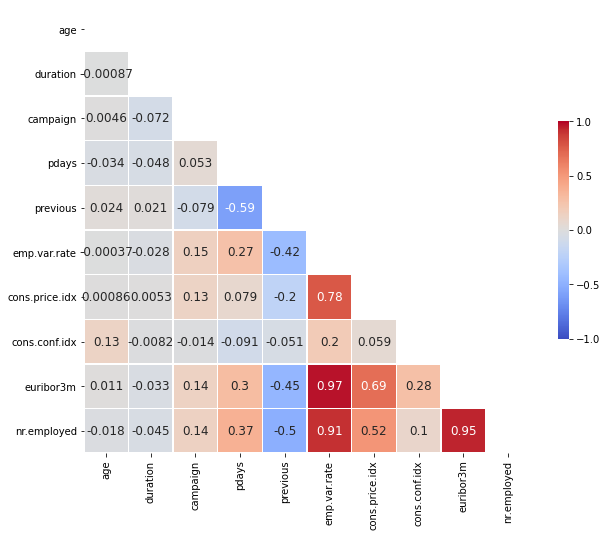

In [12]:
# Let's visualize the data correlation matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10)) 
heatmap = sns.heatmap(corr, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
# Add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True});

It's interesting to see that some parameters have a high correlation such as "emp.var.rate" and "nr.employed", "emp.var.rate" and "euribor3m", "euribor3m" and "nr.employee".

In [13]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

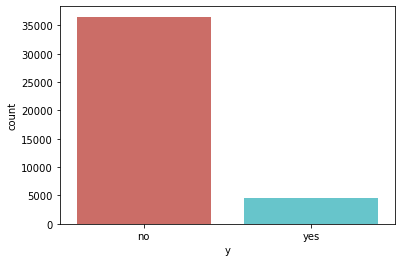

In [14]:
sns.countplot(x='y', data=df, palette='hls')
plt.show()

4,640 users out of 41,188 placed a deposit in the bank during the campaign. CVR is about 11%.

In [15]:
# df['marital'].value_counts()

In [16]:
# df['marital'].value_counts().plot.pie();

The majority of the participated users in the campaign is married.

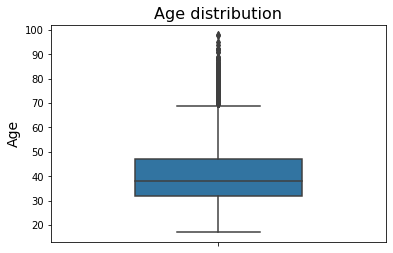

In [15]:
# # Building a box plot for age data
# bplot = sns.boxplot(y='age', data=df, width=0.5)
# bplot.axes.set_title("Age distribution",fontsize=16)
# bplot.set_ylabel("Age", fontsize=14)
# bplot.tick_params(labelsize=10)

The population is maily presented by people from around 30 to 50 years old

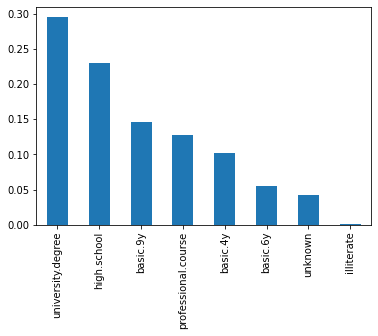

In [16]:
# df['education'].value_counts(normalize=True).plot.bar();

About 30% of the population have university degree

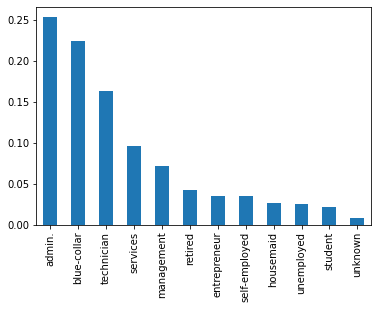

In [17]:
# df['job'].value_counts(normalize=True).plot.bar();

The majority of the population have admin, blue-collar and technician jobs

In [18]:
# df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

Most of the respondents do not have any credit in default

In [17]:
# df['housing'].value_counts().plot.pie();

There is a slight difference in the number of people who have and do not have any house

In [19]:
# df['month'].value_counts(normalize=True).plot.bar();

The last contact months for most of the users were May, June, July and August

In [21]:
df.groupby(['y']).mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


There is a drastic difference in the last contact duration (seconds) for those who placed and did not place a deposit, where converted users have longer calls. Also, there is some difference in the number of contacts performed during this campaign ("campaign"), number of days that passed by after the client was last contacted from a previous campaign ("pdays"), number of contacts performed before this campaign and for this client ("previous") and the employment variation rate.

### Questions

Based on EDA, I got the following questions:
1. What kind of characteristics have people who placed a deposit?
2. What kind of characteristics have people who did NOT place a deposit?
3. Based on the available data, is there any opportunity to increase CVR?

### Modeling Design

I am planning to use **Random Forest** to train a classification model between two classes:
* positive class - users, who placed a deposit
* negative class - users, who did NOT place a deposit.

Then, I will use **SHAP values** to understand the black box model and answer the businees questions.

<a id='prep'></a>
## Preparing Dataset to the Model

I used [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to create dummy variables for categorical attributes. This procedure needs to be done before feeding the data to the model.

In [26]:
# # One-hot encode categorical features
df = pd.get_dummies(df)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,1,0


In [21]:
# df.info()

We created dummy variables. Let us delete 'y_no' column and replace 'y_yes' by 'subscription'.

In [27]:
df.drop(['y_no'], axis=1, inplace=True)
df.rename(columns={'y_yes': 'subscription'}, inplace=True)

In [25]:
# df['subscription'].value_counts()

In [24]:
#df.info()

<a id='rfc'></a>
## Random Forest Classifier

[Random Forest](https://machinelearningmastery.com/random-forest-ensemble-in-python/) is an ensemble of decision tree algorithms. Random Forest creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. A prediction on a classification problem is the majority vote for the class label across the trees in the ensemble.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'subscription'],\
                                                    df['subscription'], stratify=df['subscription'],\
                                                    test_size = 0.4, random_state=66)

In [29]:
X_train.shape

(24712, 63)

In [30]:
X_test.shape

(16476, 63)

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=7, random_state=0, max_features='sqrt',\
                            class_weight='balanced')
rf.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = rf.predict(X_test)

# Print accuracy for the training and test sets
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.838
Accuracy on test set: 0.827


In [32]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

array([[13932,   688],
       [  926,   930]], dtype=int64)

In [33]:
# Precision
precision_score(y_test, y_pred_test, average=None)[0]

0.9376766724996635

In [34]:
# Recall
recall_score(y_test, y_pred_test, average=None)[0]

0.9529411764705882

In [35]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14620
           1       0.57      0.50      0.54      1856

    accuracy                           0.90     16476
   macro avg       0.76      0.73      0.74     16476
weighted avg       0.90      0.90      0.90     16476



<ipython-input-36-84c9483826e5>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RF_ROC', fontsize=14)


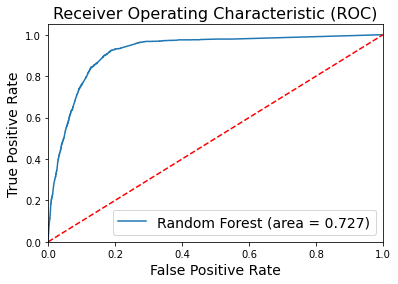

In [36]:
# Building ROC curve
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('RF_ROC', fontsize=14)
plt.show();

<a id='shap'></a>
## SHAP Values

[SHAP](https://christophm.github.io/interpretable-ml-book/shap.html) (SHapley Additive exPlanations) is a method to explain individual predictions. The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data. 

In [39]:
# Import the package !pip install shap
import shap
shap.initjs()

Let us have a look on SHAP summary plot

Wall time: 0 ns


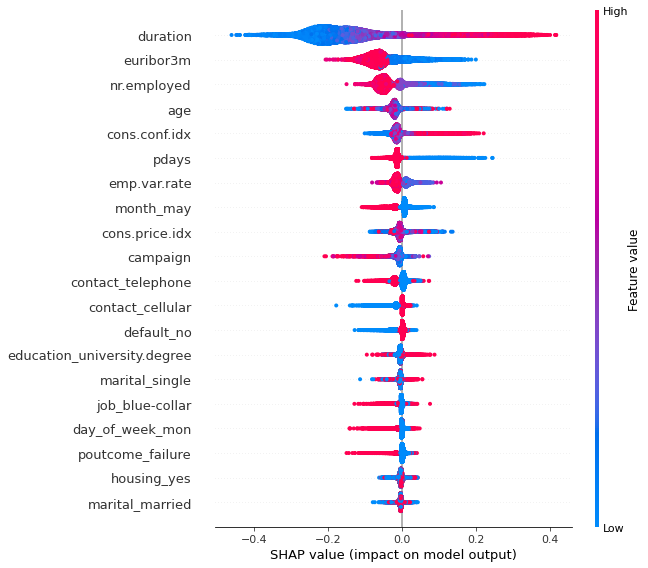

In [40]:
%time
samples = X_train

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

Based on the SHAP summary plot, we can see top 20 features and their indications of the relationship between the value of a feature and the impact on the classification model. For better understanding let us have a look at the dependence plots.

In [41]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP waterfall plot.
    
    SHAP waterfall plot is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

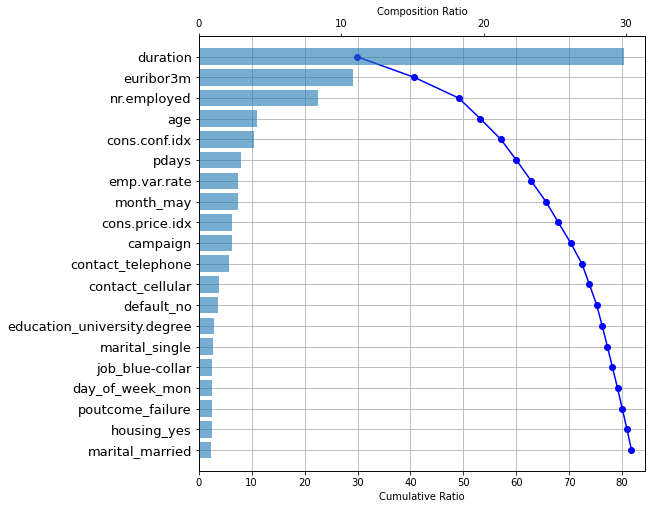

In [42]:
# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)

Based on the SHAP waterfall plot, we can say that duration is the most important feature in the model, which has more than 30% of the model's explainability. Also, these top 20 features provide more than 80% of the model's interpretation.

In [43]:
# Let's have a look on the top features and their dependence plots
top_features = ['duration', 'euribor3m', 'nr.employed', 'emp.var.rate']
feature_list = ['age', 'cons.conf.idx', 'pdays']

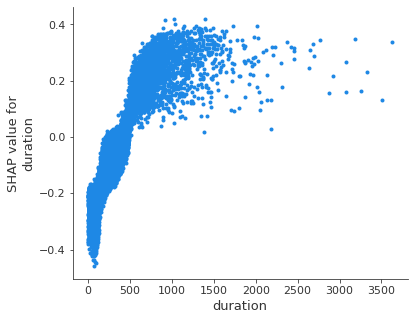

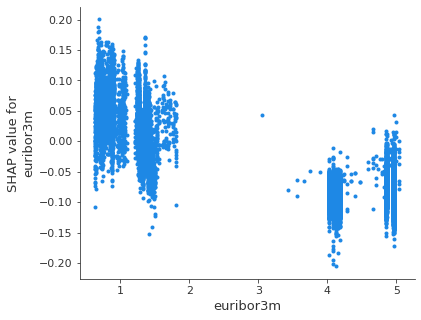

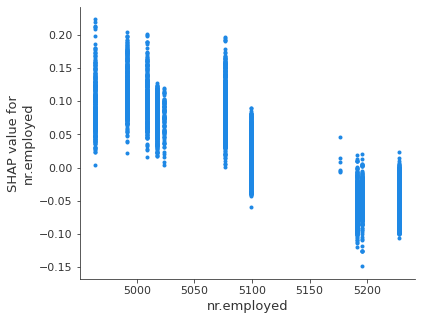

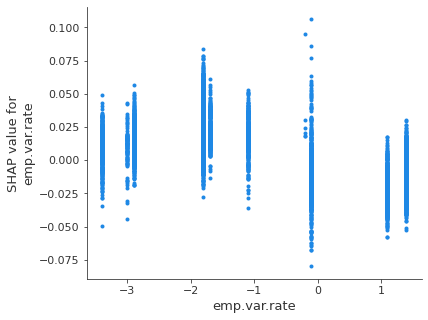

In [45]:
for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

Based on the SHAP depenndence plots, it is clear that **clients, who subscribed** to a deposit tend to have the following features:
* last contact duration longer than 500 seconds
* have euribor3m values 1 and 2
* nr.employed <= 5100
* emp.var.rate <=0

On the other hand, **clients, who did NOT subscribe** to the service may have the following features:
* last contact duration less than 500 seconds
* have euribor3m values 4 and 5
* nr.employed >=5100
* emp.var.rate >= 0

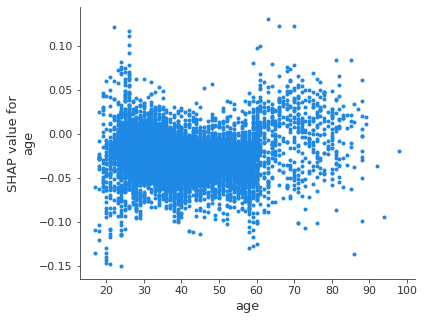

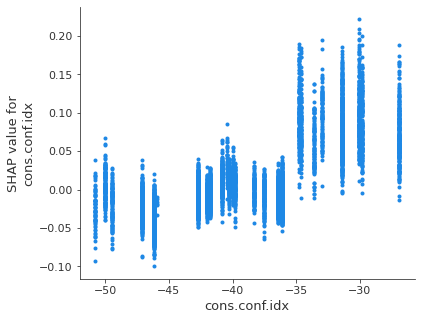

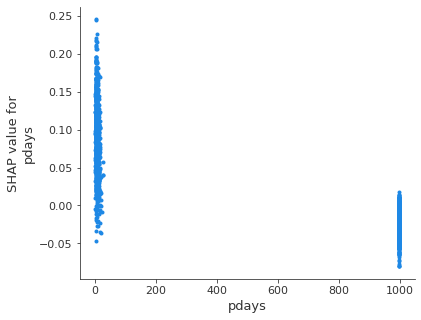

In [46]:
for feature in feature_list:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

Looking at the features, which are less important, we can say that
* the majority of the sample size aged between 20 and 60 years old is evenly distributed between two classes (subscribed and not subscribed). However, older age of a customer gives a higher probability to make a deposit
* customers, who subscribed to a term deposit have consumer confidence index >= -35
* less number of days that passed by after a client was last contacted from a previous campaign is typical for converted customers

<a id='summary'></a>
## Summary

Let us answer the business questions.

1) What kind of characteristics have people who placed a deposit?
* last contact duration longer than 500 seconds
* have euribor3m values 1 and 2
* nr.employed <= 5100
* emp.var.rate <=0

2) What kind of characteristics have people who did NOT place a deposit?
* last contact duration less than 500 seconds
* have euribor3m values 4 and 5
* nr.employed >=5100
* emp.var.rate >= 0

3) Based on the available data, is there any opportunity to increase CVR?
Based on the SHAP waterfall plot, the most important feature is duration (last contact duration, in seconds), which contributes by more than 30% to the model's explainability. Therefore, having a relatively long last contact duration (> 500 seconds) may increase CVR.

This analysis was done to grasp a practical understanding of applying SHAP values and Random Forest classifier. All the findings may do not have any connection with the real situation for placing a deposit. Also, we saw some parameters such as euribor3m, emp.var.rate, cons.price.idx, cons.conf.idx, nr.employed, which need an additional understanding of how they were derived and what are clear definitions for them.

<a id='ref'></a>
## Reference

In [78]:
# Use sklearn to export the tree 
from sklearn.tree import export_graphviz

# Write the decision tree as a dot file
visual_tree = rf.estimators_[9]
export_graphviz(visual_tree, out_file = 'best_tree.dot',
                precision = 2, filled = True, rounded = True, max_depth = None)

In [79]:
rf.estimators_

[DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=209652396),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=398764591),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=924231285),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                        random_state=1478610112),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=441365315),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                        random_state=1537364731),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=192771779),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                        random_state=1491434855),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                        random_state=1819583497),
 DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=530702035)]

In [83]:
df.head()
X1=df.drop(columns=['subscription'])
fn=X1.columns

In [84]:
fn

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oc

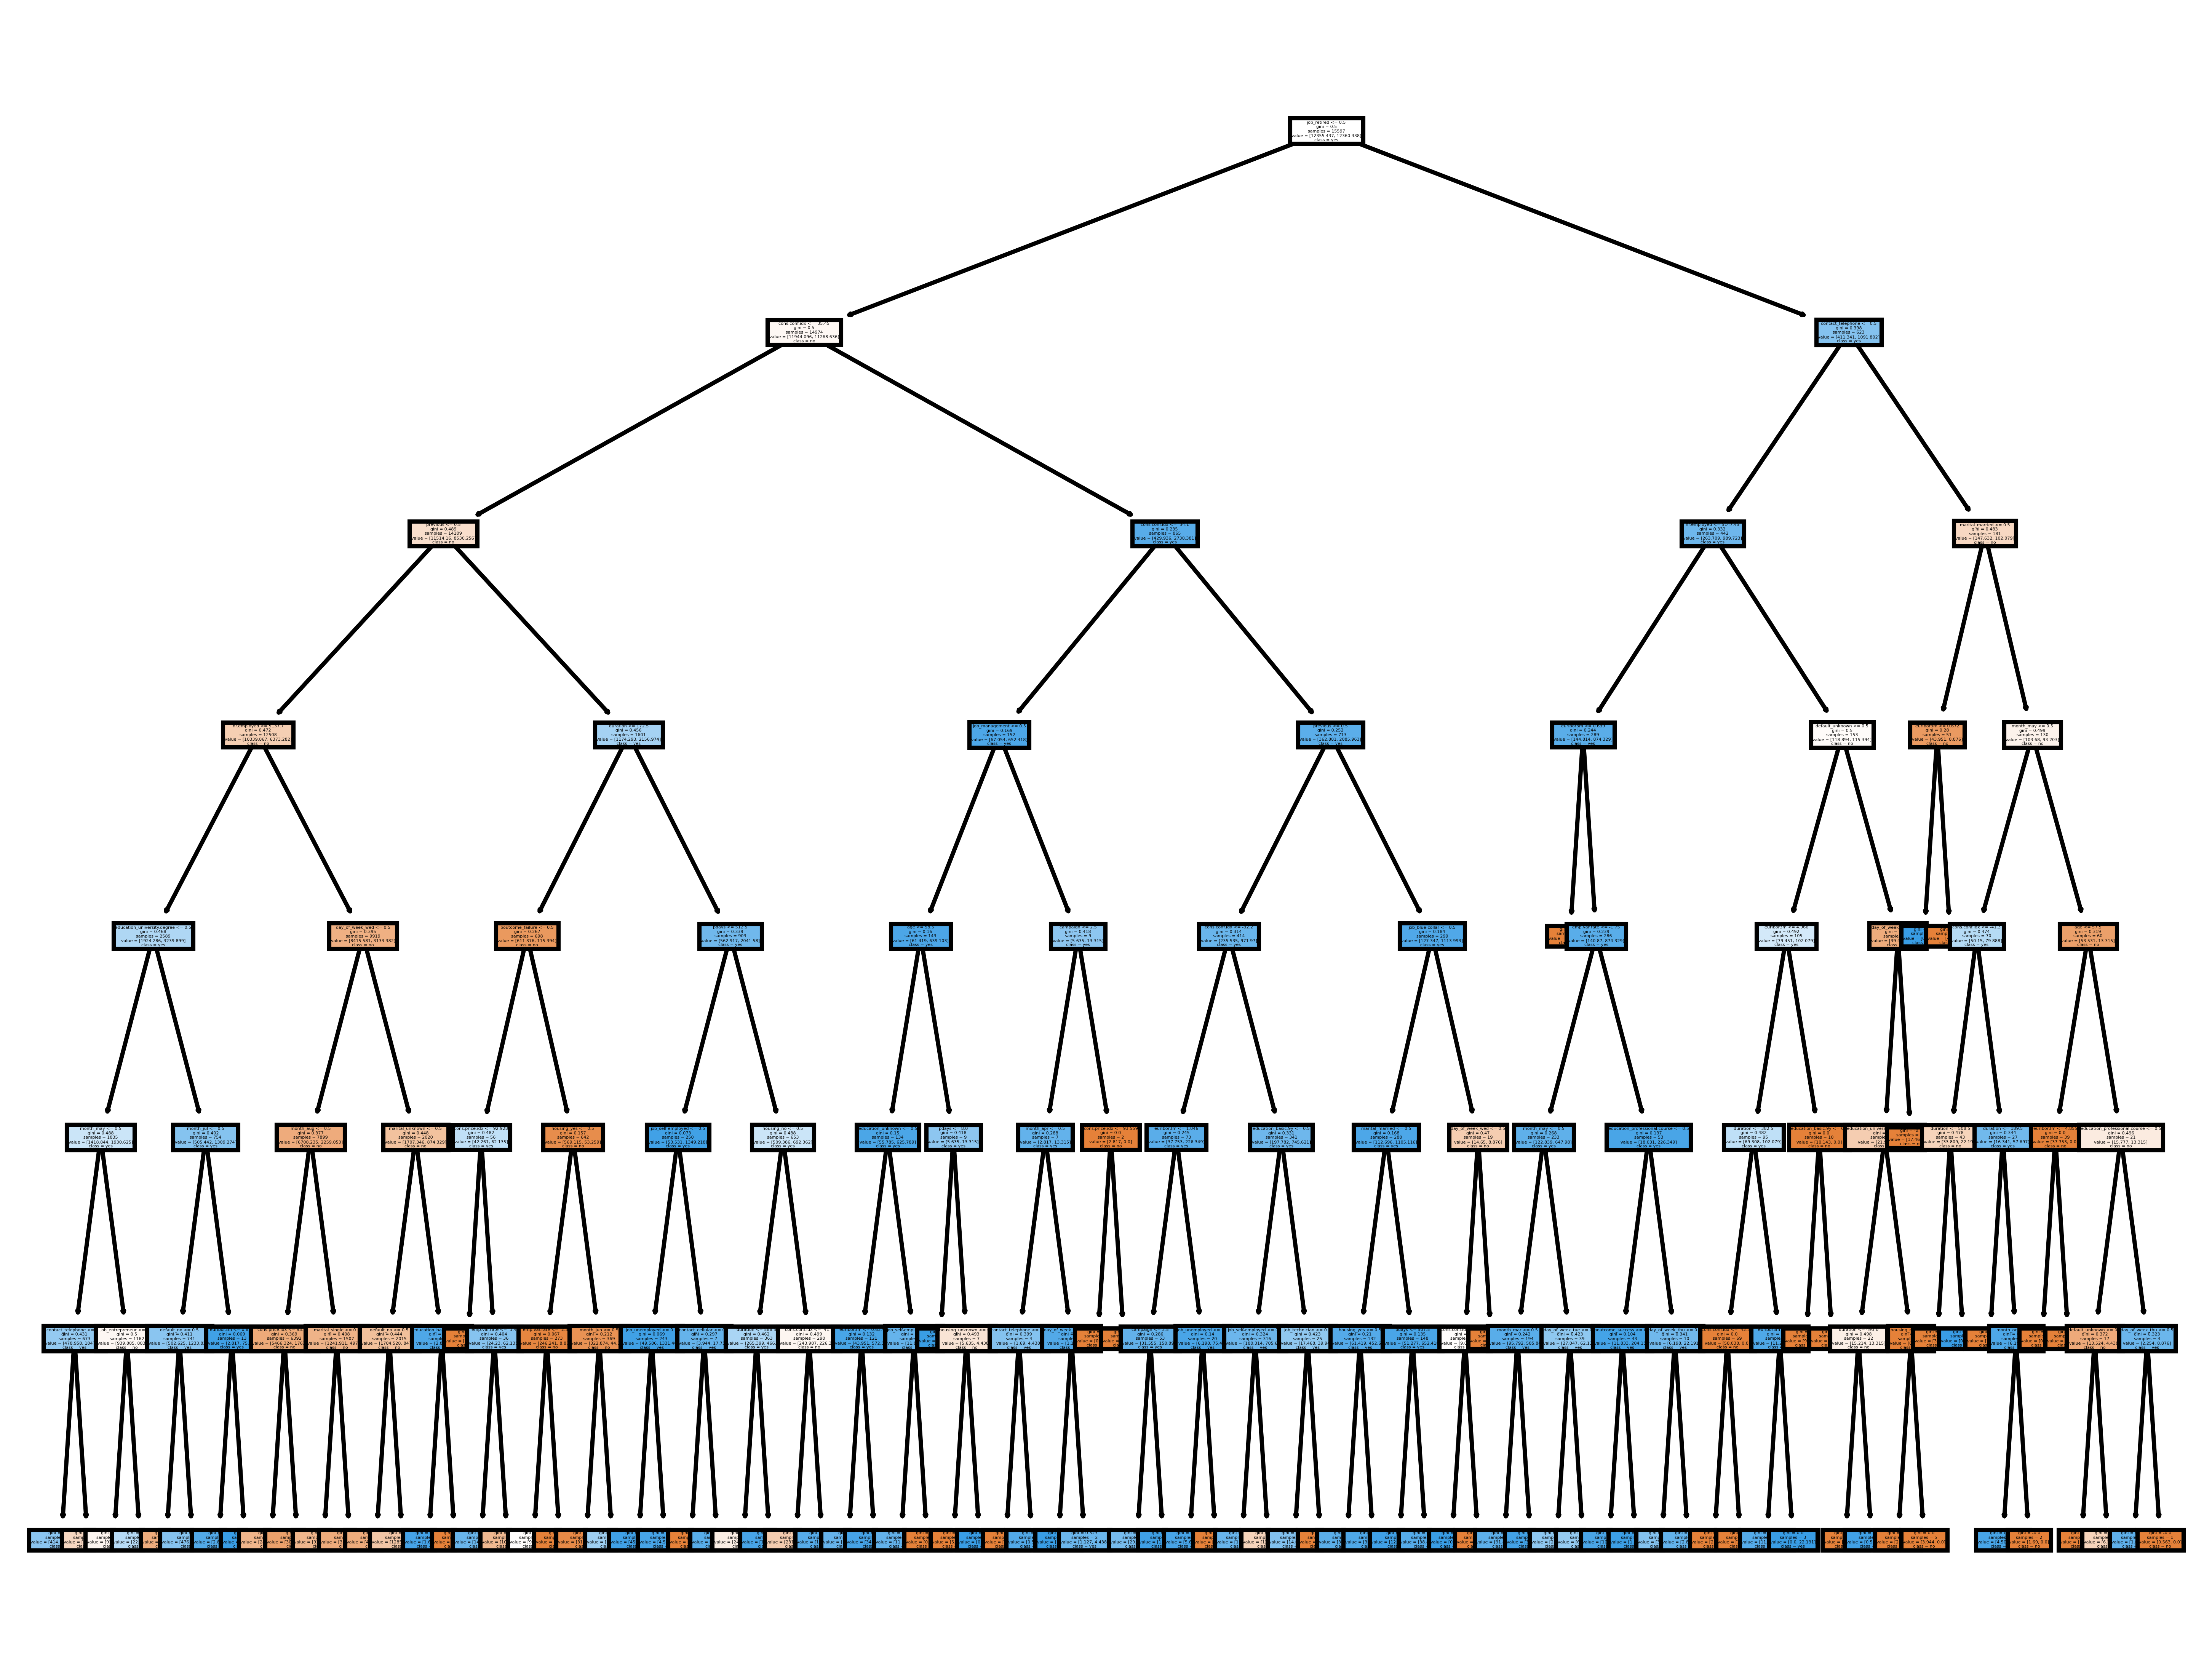

In [85]:

cn=['no', 'yes']
from sklearn.tree import plot_tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,7), dpi=800)
plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [88]:
import os     

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

# Use pydot for converting to an image file
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('C:/Users/Shahadate/labs/best_tree.dot')
graph.write_png('best_tree.png')



1. Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.
2.  Brownlee, Jason. How to Develop a Random Forest Ensemble in Python. https://machinelearningmastery.com/random-forest-ensemble-in-python/
3. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/